In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec
import numpy as np


In [26]:
grammar_df = pd.read_csv('stratifiedSentimentData/grammar_radio.csv')
topics_df = pd.read_csv('stratifiedSentimentData/radio_sample_topics.csv')
readability_df= pd.read_csv('stratifiedSentimentData/readability_radio_results.csv')
sentiment_df= pd.read_csv('stratifiedSentimentData/stratified_radio_sample_TextBlob_HYBRID.csv')

In [27]:
def safe_merge(left, right, join_key='text'):
    """Merge while preserving left DF completely and avoiding duplicate columns"""
    # Identify overlapping columns (excluding join key)
    common_cols = list(set(left.columns) & set(right.columns) - {join_key})
    
    # Keep only non-duplicate columns from right DF
    right_cols_to_keep = [col for col in right.columns if col not in common_cols or col == join_key]
    
    # Perform left join to preserve all left rows
    return pd.merge(
        left,
        right[right_cols_to_keep],
        on=join_key,
        how='left'  # This preserves all left rows
    )

# Sequential merging with automatic column deduplication
combined_df = safe_merge(sentiment_df, grammar_df)
combined_df = safe_merge(combined_df, topics_df)
combined_df = safe_merge(combined_df, readability_df)

print(combined_df.head())

  station            range_key  \
0    KAWC  2024-11-30 09:00:00   
1    KAWC  2024-09-26 06:00:00   
2    KVOI  2024-11-15 15:00:00   
3    KQNA  2024-11-03 21:00:00   
4    KVOI  2024-09-01 00:00:00   

                                                text state  total_sentences  \
0   Weather forecast for Yuma today is mostly sun...    AZ             1130   
1   K-A-W-C.Classical music of Peter Van de Graaf...    AZ             1713   
2   At Cortero, Tucson's only live local news and...    AZ             2706   
3   Can't get enough of YCCA's Hammer Time show?W...    AZ             2285   
4   Under the Gaza city of Rafa, including that o...    AZ             1602   

   positive_count  negative_count  neutral_count  positive_proportion  \
0             398             151            581             0.352212   
1             520             245            948             0.303561   
2             891             302           1513             0.329268   
3             774           

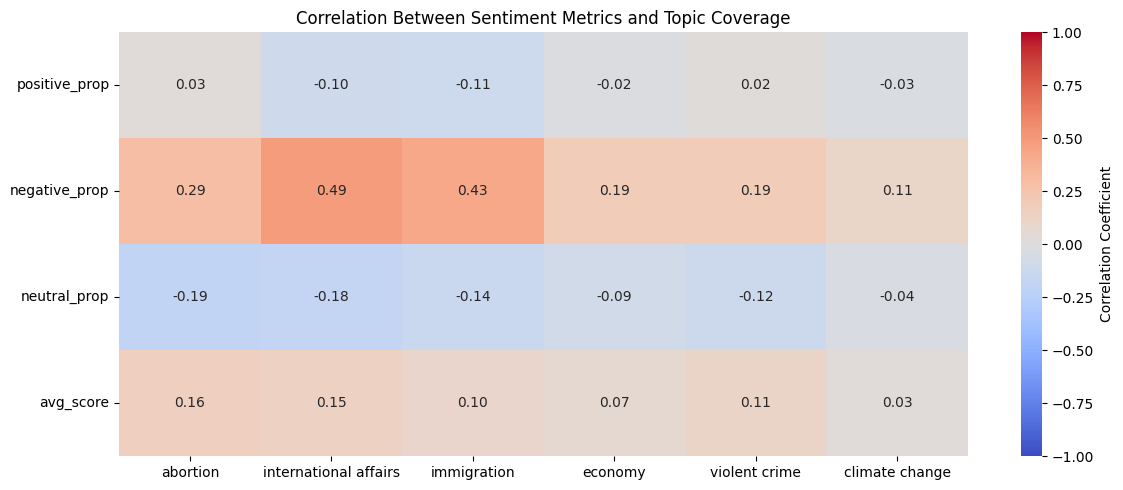

In [28]:
# Select only the relevant columns
topics = ['abortion', 'international affairs', 'immigration', 
          'economy', 'violent crime', 'climate change']
sentiment_cols = ['positive_prop', 'negative_prop', 'neutral_prop', 'avg_score']

# Calculate correlation matrix
corr_matrix = combined_df[topics + sentiment_cols].corr()

# Plot only sentiment-topic correlations
plt.figure(figsize=(12, 5))
sns.heatmap(corr_matrix.loc[sentiment_cols, topics], 
            annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Between Sentiment Metrics and Topic Coverage')
plt.tight_layout()
plt.show()

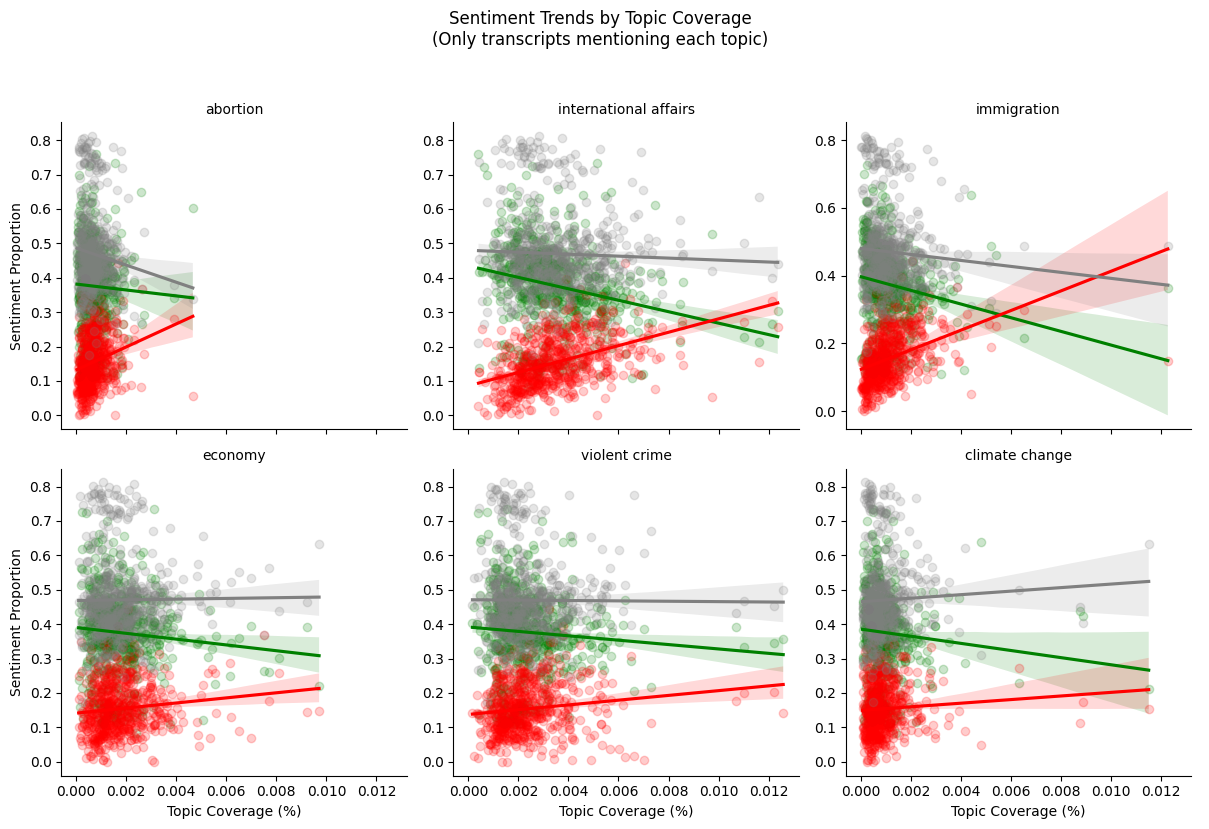

In [29]:
# Prepare data for faceting
facet_data = combined_df.melt(id_vars=sentiment_cols,
                             value_vars=topics,
                             var_name='topic',
                             value_name='coverage')

# Filter out zero-coverage documents
facet_data = facet_data[facet_data['coverage'] > 0]

g = sns.FacetGrid(facet_data, col='topic', col_wrap=3, height=4, sharey=False)
g.map(sns.regplot, 'coverage', 'positive_prop', color='green', scatter_kws={'alpha':0.2})
g.map(sns.regplot, 'coverage', 'negative_prop', color='red', scatter_kws={'alpha':0.2})
g.map(sns.regplot, 'coverage', 'neutral_prop', color='gray', scatter_kws={'alpha':0.2})
g.set_axis_labels('Topic Coverage (%)', 'Sentiment Proportion')
g.set_titles("{col_name}")
g.add_legend()
plt.suptitle('Sentiment Trends by Topic Coverage\n(Only transcripts mentioning each topic)', y=1.03)
plt.tight_layout()
plt.show()

In [31]:
states = ['AZ', 'GA', 'MI', 'NC', 'NV', 'PA', 'WI']

# Calculate mean sentiment proportions by state
state_sentiments = []
for state in states:
    state_docs = combined_df[combined_df['state'] == state]
    avg_sentiment = state_docs[sentiment_cols].mean()
    state_sentiments.append({
        'state': state,
        'positive': avg_sentiment['positive_prop'],
        'negative': avg_sentiment['negative_prop'],
        'neutral': avg_sentiment['neutral_prop'],
        'doc_count': len(state_docs)
    })

state_df = pd.DataFrame(state_sentiments)

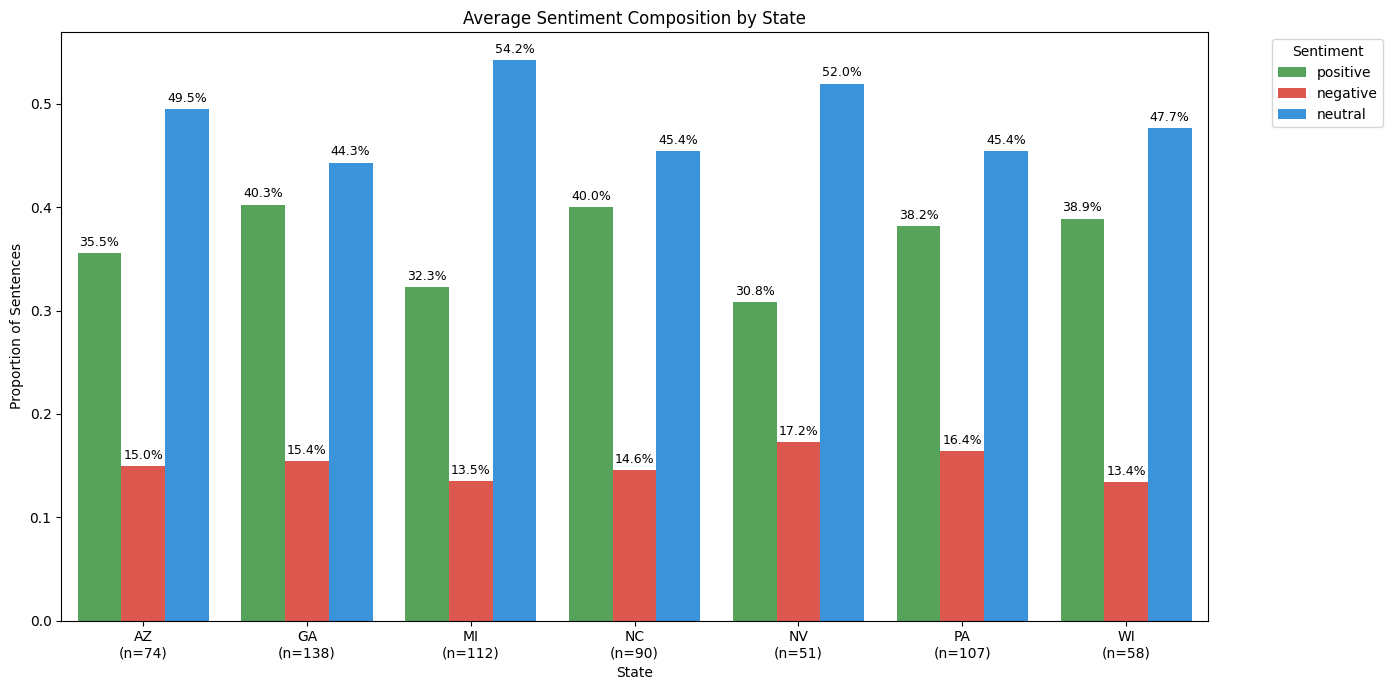

In [34]:
# Prepare data
melted_state = state_df.melt(id_vars=['state', 'doc_count'], 
                            value_vars=['positive', 'negative', 'neutral'],
                            var_name='sentiment', 
                            value_name='proportion')

#Plot
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=melted_state, x='state', y='proportion', hue='sentiment',
                palette={'positive':'#4CAF50', 'negative':'#F44336', 'neutral':'#2196F3'},
                order=states)

plt.title('Average Sentiment Composition by State')
plt.ylabel('Proportion of Sentences')
plt.xlabel('State')

# Add percentage annotations at TOP of each segment
for p in ax.patches:
    height = p.get_height()
    if height > 0.005:  # Only label segments >0.5%
        ax.annotate(f'{height:.1%}',
                   (p.get_x() + p.get_width() / 2., p.get_y() + height),  # y-position at top
                   ha='center', va='bottom',  # Align text above the bar
                   xytext=(0, 3),  # Small vertical offset
                   textcoords='offset points',
                   fontsize=9,
                   color='black')

# Add document counts
labels = [f"{state}\n(n={state_df[state_df['state']==state]['doc_count'].values[0]})" 
              for state in states]
ax.set_xticks(range(len(states)))  # Explicitly set tick positions
ax.set_xticklabels(labels, rotation=0)  # Now safe to set labels

plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [39]:
from scipy.stats import chi2_contingency

# 1. Aggregate sentiment proportions by state
state_sentiment_means = combined_df.groupby('state')[['positive_prop', 'negative_prop', 'neutral_prop']].mean()

# 2. Convert proportions to approximate counts (scaling by average sentences per doc)
avg_sentences = combined_df['sentence_count'].mean()  # Use your actual column name
observed_counts = (state_sentiment_means * avg_sentences).round().astype(int)

print("Approximate Sentence Counts by Sentiment and State:")
display(observed_counts)

# 3. Chi-square test on full distribution
chi2, p, dof, expected = chi2_contingency(observed_counts)

# 4. Calculate Cramér's V
n = observed_counts.sum().sum()
min_dim = min(observed_counts.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print(f"\nResults:")
print(f"χ² = {chi2:.1f}, p = {p:.4f}, Cramér's V = {cramers_v:.3f}")

Approximate Sentence Counts by Sentiment and State:


,positive_prop,negative_prop,neutral_prop
state,,,
AZ,165,70,230
GA,187,72,206
MI,150,63,252
NC,186,68,211
NV,143,80,241
PA,177,76,211
WI,181,62,221



Results:
χ² = 22.6, p = 0.0315, Cramér's V = 0.059
